# Explatory Data Analysis (EDA)
This notebook contains the Exploratory Data Analysis for the project, starting from the Trentino database, created by G. Barlacchi and presented in this [paper](https://www.nature.com/articles/sdata201555). The data analysed is social (Twitter), weather (precipitations, temperature, wind) and electrical.

First, let's import some useful libraries.

In [157]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point
from shapely import wkt

import json
import sys

import warnings
warnings.filterwarnings('ignore')

## Twitter and weather

### Loading data

Initially, we consider only the Twitter and weather data. So, let's load the data contained in the files `meteotrentino-weather-station-data.json` and `social-pulse-trentino.geojson`:

In [158]:
with open('../data/raw/meteotrentino-weather-station-data.json') as json_file:
    data_weather = json.load(json_file)
with open('../data/raw/social-pulse-trentino.geojson') as json_file:
    data_twitter = json.load(json_file)

It is necessary to import also the Trentino geojson grid:

In [159]:
grid_path = '../data/raw/trentino-grid.geojson'
df_grid = gpd.read_file(grid_path)

Now, from the json files, we extract only the features (they contain also metadata like the coordinate system, EPSG:4326):

In [160]:
twitter_features = gpd.GeoDataFrame(data_twitter['features'])
weather_features = gpd.GeoDataFrame(data_weather['features'])

They look something like this:

In [161]:
twitter_features.head()

,created,timestamp,user,geomPoint.geom,municipality.name,municipality.acheneID,language,entities
0,2013-11-01T00:04:16,1383260656,5fd4f31f75,"{'type': 'Point', 'coordinates': [11.13, 46.07]}",Trento,http://dandelion.eu/resource/05a192433bede90cd...,it,[]
1,2013-11-01T00:01:14,1383260474,68c0e98182,"{'type': 'Point', 'coordinates': [10.83, 46.23]}",Pinzolo,http://dandelion.eu/resource/96e35a90e246ca017...,tl,[http://it.dbpedia.org/resource/Madonna_di_Cam...
2,2013-11-01T00:43:03,1383262983,abe21fc052,"{'type': 'Point', 'coordinates': [11.46, 46.29]}",Cavalese,http://dandelion.eu/resource/01f847397f180d6c0...,en,"[http://dbpedia.org/resource/Coven, http://dbp..."
3,2013-11-01T00:38:37,1383262717,94d1efbbfd,"{'type': 'Point', 'coordinates': [11.04, 45.89]}",Rovereto,http://dandelion.eu/resource/1841c30a560050875...,it,[]
4,2013-11-01T00:45:40,1383263140,d261d03075,"{'type': 'Point', 'coordinates': [11.12, 46.2]}",San Michele all'Adige,http://dandelion.eu/resource/32ca86fe3c8f5988a...,ru,[http://it.dbpedia.org/resource/Rotari]


In [162]:
weather_features.head()

,station,geomPoint.geom,elevation,date,timestamp,minTemperature,maxTemperature,precipitation,minWind,maxWind,...,winds.2130,winds.2145,winds.2200,winds.2215,winds.2230,winds.2245,winds.2300,winds.2315,winds.2330,winds.2345
0,T0071,"{'type': 'Point', 'coordinates': [10.79582897,...",905,2013-11-01,1383260400,4.5,12.3,False,0.0,2.5,...,0@183,,0@157,,0.4@228,0.3@248,,0@201,0@199,
1,T0032,"{'type': 'Point', 'coordinates': [11.25371981,...",1155,2013-11-01,1383260400,6.5,10.2,False,NaN,NaN,...,,,,,,,,,,
2,T0096,"{'type': 'Point', 'coordinates': [11.6645808, ...",1205,2013-11-01,1383260400,6.5,11.8,False,NaN,NaN,...,,,,,,,,,,
3,T0074,"{'type': 'Point', 'coordinates': [10.91841055,...",720,2013-11-01,1383260400,6.2,13.6,False,0.0,4.8,...,0.3@198,0.3@196,0.4@236,,0.9@15,0.6@345,1@244,0.5@192,0@157,
4,T0101,"{'type': 'Point', 'coordinates': [11.07973339,...",201,2013-11-01,1383260400,11.1,16.3,False,NaN,NaN,...,,,,,,,,,,


We decide to remove unnecessary features to `twitter_features` (user, municipality ID, language, entities):

In [163]:
twitter_features = twitter_features.drop('entities', axis=1)
twitter_features = twitter_features.drop('municipality.acheneID', axis=1)
twitter_features = twitter_features.drop('language', axis=1)
twitter_features = twitter_features.drop('user', axis=1)

Our goal now is to associate to each tweet its weather data, but there are two problems:
1. weather data is collected every 15 minutes and not every second;
2. weather data is referred to a weather station and not to the specific location of the tweet.


### 15-minutes blocks

Let's solve the first problem by assigning to each tweet its 15-minutes block. We need to split the `created` column into date and time:

In [164]:
twitter_features['date'] = twitter_features['created'].str.split('T').str[0]
twitter_features['time'] = twitter_features['created'].str.split('T').str[1]
twitter_features = twitter_features.drop('created', axis=1)
twitter_features = twitter_features[['date', 'time', 'timestamp', 'geomPoint.geom', 'municipality.name']]

Since we need blocks of 15 minutes, we can ignore seconds:

In [165]:
twitter_features['time'] = twitter_features['time'].str.rsplit(':', n=1).str[0]

For the blocks, it is just a simple integer division, but it is important to write the blocks in the format HHMM, to match the weather data:

In [166]:
minutes = twitter_features['time'].str.rsplit(':', n=1).str[1].astype(int)
minutes = ((minutes//15)*15).astype(str).str.zfill(2)

hours = twitter_features['time'].str.rsplit(':', n=1).str[0]

twitter_features['hour_blocks'] = hours + minutes

In [167]:
twitter_features.head()

,date,time,timestamp,geomPoint.geom,municipality.name,hour_blocks
0,2013-11-01,00:04,1383260656,"{'type': 'Point', 'coordinates': [11.13, 46.07]}",Trento,0000
1,2013-11-01,00:01,1383260474,"{'type': 'Point', 'coordinates': [10.83, 46.23]}",Pinzolo,0000
2,2013-11-01,00:43,1383262983,"{'type': 'Point', 'coordinates': [11.46, 46.29]}",Cavalese,0030
3,2013-11-01,00:38,1383262717,"{'type': 'Point', 'coordinates': [11.04, 45.89]}",Rovereto,0030
4,2013-11-01,00:45,1383263140,"{'type': 'Point', 'coordinates': [11.12, 46.2]}",San Michele all'Adige,0045


### Stations dataframe and geometry

The first problem is now assessed, and we should build a stations dataframe to work with them:

In [168]:
df_stations = weather_features[['station', 'geomPoint.geom']]
df_stations.drop_duplicates(subset='station', keep='first', inplace=True)

For all data, it is necessary to transform the geometry column using the library `shapely.geometry.Point`

In [169]:
df_stations['geometry'] = df_stations['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
df_stations.drop(columns=['geomPoint.geom'],inplace=True)
df_stations = gpd.GeoDataFrame(df_stations, geometry='geometry')

In [170]:
twitter_features['geometry'] = twitter_features['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
twitter_features.drop(columns=['geomPoint.geom'],inplace=True)
twitter_features = gpd.GeoDataFrame(twitter_features, geometry='geometry')

In [171]:
weather_features['geometry'] = weather_features['geomPoint.geom'].apply(lambda x:Point(x['coordinates'][0], x['coordinates'][1]))
weather_features.drop(columns=['geomPoint.geom'],inplace=True)
weather_features = gpd.GeoDataFrame(weather_features, geometry='geometry')

### Choosing the station

To solve the second problem, we decide to assign to each tweet its nearest station, calculating the distance between the tweet location and the station location.

Since we are on a curved surface, for two points that have:
\begin{align}
    &\Delta \lambda = \lambda_2 - \lambda_1 \quad \text{the difference of longitude} \\
    &\Delta \phi = \phi_2 - \phi_1 \quad \text{the difference of latitude}\ ,
\end{align}
we use the [Haversine distance](https://en.wikipedia.org/wiki/Haversine_formula):
\begin{equation}
d = 2r\arcsin{\sqrt{\sin^2\left(\frac{\Delta\phi}{2}\right) + \cos\phi_1 \cos\phi_2 \sin^2\left(\frac{\Delta\lambda}{2}\right)}}
\end{equation}
and we search through each station to find the one with the minimum distance.

We start by defining the Haversine distance function (it returns the distance in km):

In [172]:
def haversine_distance(lat1, lon1, lat2, lon2):    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula    
    dlat = lat2 - lat1[:, np.newaxis]
    dlon = lon2 - lon1[:, np.newaxis]    
    a = np.sin(dlat / 2)**2 + np.cos(lat1[:, np.newaxis]) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Earth's radius in kilometers (6371 km)    
    radius = 6371
    
    return radius * c

And it is now just of matter of computing it for every tweet and station:

In [173]:
twitter_lat = np.array(twitter_features.get_coordinates()['y'])
twitter_lon = np.array(twitter_features.get_coordinates()['x'])
station_lat = np.array(df_stations.get_coordinates()['y'])
station_lon = np.array(df_stations.get_coordinates()['x'])

In [174]:
distances = haversine_distance(twitter_lat, twitter_lon, station_lat, station_lon)

In [175]:
nearest_station_index = np.argmin(distances, axis=1).flatten()

In [176]:
twitter_features['station'] = df_stations['station'].iloc[nearest_station_index].values

In [177]:
twitter_features.head()

,date,time,timestamp,municipality.name,hour_blocks,geometry,station
0,2013-11-01,00:04,1383260656,Trento,0000,POINT (11.13000 46.07000),T0129
1,2013-11-01,00:01,1383260474,Pinzolo,0000,POINT (10.83000 46.23000),T0071
2,2013-11-01,00:43,1383262983,Cavalese,0030,POINT (11.46000 46.29000),T0367
3,2013-11-01,00:38,1383262717,Rovereto,0030,POINT (11.04000 45.89000),T0147
4,2013-11-01,00:45,1383263140,San Michele all'Adige,0045,POINT (11.12000 46.20000),T0408


It is nice to look at a plot of the tweets grouped by station.

In [178]:
import matplotlib.colors as mcolors

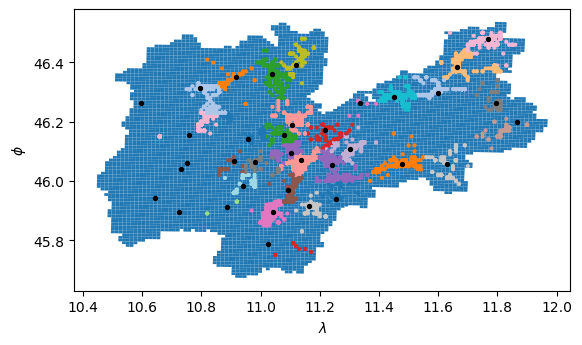

In [179]:
palette = sns.color_palette("tab20", len(df_stations))
cmap = mcolors.ListedColormap(palette)
station_to_color = {station: palette[i] for i, station in enumerate(stations)}
ax = df_grid.plot()
twitter_features.plot(column='station', ax=ax, cmap=cmap, markersize=4)
df_stations.plot(ax=ax, color='black', markersize=8)
plt.xlabel(r"$\lambda$");
plt.ylabel(r"$\phi$");

### Merging

Now the dataframe `twitter_features` has a `station` column and it can be merged with the `weather_features` dataframe by that column (and by date, since `weather_features` has a date column!

In [180]:
df = pd.merge(twitter_features, weather_features, on=['station', 'date'], how='left')

In [181]:
df.head()

,date,time,timestamp_x,municipality.name,hour_blocks,geometry_x,station,elevation,timestamp_y,minTemperature,...,winds.2145,winds.2200,winds.2215,winds.2230,winds.2245,winds.2300,winds.2315,winds.2330,winds.2345,geometry_y
0,2013-11-01,00:04,1383260656,Trento,0000,POINT (11.13000 46.07000),T0129,312.0,1.383260e+09,11.7,...,1.4@38,0.8@100,1.1@121,1.5@96,1.4@67,2@86,1.4@79,1.1@70,1.6@59,POINT (11.13565 46.07185)
1,2013-11-01,00:01,1383260474,Pinzolo,0000,POINT (10.83000 46.23000),T0071,905.0,1.383260e+09,4.5,...,,0@157,,0.4@228,0.3@248,,0@201,0@199,,POINT (10.79583 46.31340)
2,2013-11-01,00:43,1383262983,Cavalese,0030,POINT (11.46000 46.29000),T0367,958.0,1.383260e+09,7.0,...,,,,,,0.1@216,0.2@205,,0.6@264,POINT (11.45171 46.28478)
3,2013-11-01,00:38,1383262717,Rovereto,0030,POINT (11.04000 45.89000),T0147,203.0,1.383260e+09,11.0,...,0.8@48,0.8@152,0.5@111,0.8@13,0.5@164,0.9@132,1.5@137,0.7@3,0.9@359,POINT (11.04379 45.89644)
4,2013-11-01,00:45,1383263140,San Michele all'Adige,0045,POINT (11.12000 46.20000),T0408,204.0,1.383260e+09,9.6,...,,,,,,,,,,POINT (11.10461 46.18723)


It is noticeable that after the merge some columns are named with a `_x` or `_y`suffix. That's because they have the same name in the parents dataframes but we do not merge by those. We decide to remove from `df` the columns corresponding to the location of the station and the timestamp of the station.

In [182]:
df = df.drop(['timestamp_y', 'geometry_y'], axis=1)
df = df.rename(columns={"geometry_x": "geometry", "timestamp_x": "timestamp"})

Lastly (just for this first merge, don't worry), we need to select the right temperature, precipitation and wind values to keep in the dataframe, since we just need those that match the 15-minutes blocks of the tweets.

In [183]:
def get_temperature(row):
    str = 'temperatures.' + row['hour_blocks']
    return row[str]
df['temperature'] = df.apply(get_temperature, axis=1)

In [184]:
def get_precipitation(row):
    str = 'precipitations.' + row['hour_blocks']
    return row[str]
df['precipitation'] = df.apply(get_precipitation, axis=1)

In [185]:
def get_wind(row):
    str = 'winds.' + row['hour_blocks']
    return row[str]
df['wind'] = df.apply(get_wind, axis=1)

And we can drop all the other temperature, precipitation and wind columns:

In [186]:
df = df.drop([col for col in df.columns if col.startswith('temperatures.')], axis=1)
df = df.drop([col for col in df.columns if col.startswith('precipitations.')], axis=1)
df = df.drop([col for col in df.columns if col.startswith('winds.')], axis=1)

In [187]:
df.head()

,date,time,timestamp,municipality.name,hour_blocks,geometry,station,elevation,minTemperature,maxTemperature,precipitation,minWind,maxWind,temperature,wind
0,2013-11-01,00:04,1383260656,Trento,0000,POINT (11.13000 46.07000),T0129,312.0,11.7,16.0,0.0,0.2,2.0,13.2,1@47
1,2013-11-01,00:01,1383260474,Pinzolo,0000,POINT (10.83000 46.23000),T0071,905.0,4.5,12.3,0.0,0.0,2.5,8.4,0.1@205
2,2013-11-01,00:43,1383262983,Cavalese,0030,POINT (11.46000 46.29000),T0367,958.0,7.0,13.0,0.0,0.0,1.8,8.8,
3,2013-11-01,00:38,1383262717,Rovereto,0030,POINT (11.04000 45.89000),T0147,203.0,11.0,18.4,0.0,0.2,1.9,13.2,0.6@7
4,2013-11-01,00:45,1383263140,San Michele all'Adige,0045,POINT (11.12000 46.20000),T0408,204.0,9.6,16.9,0.0,NaN,NaN,11.6,


At this point, Twitter and weather data are merged. Let's move on to electrical data.

## Electrical

It is now time to add the electrical data, contained in the files:
- `SET-LMD-nov-2013.csv`: Line Measurement Dataset (November)
- `SET-LMD-dec-2013.csv`: Line Measurement Dataset (December)
- `SET-CSD.csv`: Customer Site Dataset (November)

### Loading data

We shall import the LMD from November and December and concat it.

In [188]:
df_LMD_nov = pd.read_csv('../data/raw/SET-LMD-nov-2013.csv')
df_LMD_dec = pd.read_csv('../data/raw/SET-LMD-dec-2013.csv')
df_LMD = pd.concat([df_LMD_nov, df_LMD_dec], ignore_index=True)

The `df_LMD` dataframe contains the electric current value for each electric line at a specific time (data is collected every 10 minutes):

In [189]:
df_LMD.head()

,LINEID,TIME,VALUE
0,DG1000420,2013-11-01 00:00,37.439999
1,DG1000420,2013-11-01 00:10,37.439999
2,DG1000420,2013-11-01 00:20,36.000000
3,DG1000420,2013-11-01 00:30,35.279999
4,DG1000420,2013-11-01 00:40,35.279999


Let's import the CSD, too.

In [190]:
df_CSD = pd.read_csv('../data/raw/SET-CSD.csv')

The `df_CSD` dataframe contains the number of sites connected to an electrical line in a certain cell (the same cells of `df_grid`):

In [191]:
df_CSD.head()

,SQUAREID,LINEID,NR_SITES
0,155,DG1031221,4
1,272,DG1031221,72
2,273,DG1031221,21
3,276,DG1003117,34
4,277,DG1003117,3


In [192]:
## df_twitter is df, REMOVE THIS

### 10-minutes blocks

Since electrical data is collected every 10 minutes, we need to remake the time blocks. The procedure is the same as before with the 15-minutes ones.

In [193]:
df_twitter_electric = df

In [194]:
minutes = df_twitter_electric['time'].str.rsplit(':', n=1).str[1].astype(int)
minutes = ((minutes // 10)*10).astype(str).str.zfill(2)

hours = df_twitter_electric['time'].str.rsplit(':', n=1).str[0]

df_twitter_electric['hour_blocks'] = hours + ':' + minutes

In [201]:
df_twitter_electric.head()

,date,time,timestamp,municipality.name,hour_blocks,geometry,station,elevation,minTemperature,maxTemperature,precipitation,minWind,maxWind,temperature,wind
0,2013-11-01,00:04,1383260656,Trento,00:00,POINT (11.13000 46.07000),T0129,312.0,11.7,16.0,0.0,0.2,2.0,13.2,1@47
1,2013-11-01,00:01,1383260474,Pinzolo,00:00,POINT (10.83000 46.23000),T0071,905.0,4.5,12.3,0.0,0.0,2.5,8.4,0.1@205
2,2013-11-01,00:43,1383262983,Cavalese,00:40,POINT (11.46000 46.29000),T0367,958.0,7.0,13.0,0.0,0.0,1.8,8.8,
3,2013-11-01,00:38,1383262717,Rovereto,00:30,POINT (11.04000 45.89000),T0147,203.0,11.0,18.4,0.0,0.2,1.9,13.2,0.6@7
4,2013-11-01,00:45,1383263140,San Michele all'Adige,00:40,POINT (11.12000 46.20000),T0408,204.0,9.6,16.9,0.0,NaN,NaN,11.6,


### Merging by grid

We can now merge `df_twitter_electric` and `df_grid`, so that each tweet has its cell ID. It is useful to do this with the geopandas function `sjoin`:

In [202]:
df_merged = gpd.sjoin(df_twitter_electric, df_grid, how='inner', predicate='within').drop('index_right', axis=1)

In [203]:
df_merged.head()

,date,time,timestamp,municipality.name,hour_blocks,geometry,station,elevation,minTemperature,maxTemperature,precipitation,minWind,maxWind,temperature,wind,cellId
0,2013-11-01,00:04,1383260656,Trento,00:00,POINT (11.13000 46.07000),T0129,312.0,11.7,16.0,0.0,0.2,2.0,13.2,1@47,5201
1,2013-11-01,00:01,1383260474,Pinzolo,00:00,POINT (10.83000 46.23000),T0071,905.0,4.5,12.3,0.0,0.0,2.5,8.4,0.1@205,7167
2,2013-11-01,00:43,1383262983,Cavalese,00:40,POINT (11.46000 46.29000),T0367,958.0,7.0,13.0,0.0,0.0,1.8,8.8,,8151
3,2013-11-01,00:38,1383262717,Rovereto,00:30,POINT (11.04000 45.89000),T0147,203.0,11.0,18.4,0.0,0.2,1.9,13.2,0.6@7,2855
4,2013-11-01,00:45,1383263140,San Michele all'Adige,00:40,POINT (11.12000 46.20000),T0408,204.0,9.6,16.9,0.0,NaN,NaN,11.6,,6838


### Electrical consumption of cells

We would like to have, for each tweet, the total electrical consumption of the cell it is tweeted from and the consumption per site. Since a cell can be crossed by many lines, some calculations have to be carried out.

![](electrical_lines.png)

In this example, let's call the lines $j$, their total current $I_j$ and their total number of sites $N_j$. The grid cells are instead labelled with $i$, so let's call the number of sites per cell $n_{ij}$.

To calculate the total current in the $i$-th cell $I_i^{cell}$ we need to sum over the lines crossing it:
\begin{equation}
    I_i^{cell} = I_1\frac{n_{i1}}{N_1} + I_2\frac{n_{i2}}{N_2} + \dots = \sum_j I_j\frac{n_{ij}}{N_j}
\end{equation}

To calculate the current per site it's just a matter of dividing $I_i^{cell}$ by the number of sites per cell:
\begin{equation}
    I_i^{site} = \frac{\sum_j I_j\frac{n_{ij}}{N_j}}{\sum_j n_{ij}}
\end{equation}

We can extract the values of:
- $I_j$ from `df_LMD['VALUE']`
- $n_{ij}$ from `df_CSD['NR_SITES']`
- $N_j = \sum_i n_{ij}$


It is useful to exploit the pandas `groupby` function to sum over the number of sites for each line:

In [207]:
df_lines = df_CSD.groupby(['LINEID']).sum()

In [208]:
df_lines = pd.merge(df_LMD, df_lines, on='LINEID', how='inner')
df_lines = df_lines.rename(columns={"NR_SITES": "TOT_SITES"})
df_lines = df_lines.drop('SQUAREID', axis=1)

And here we merge the data with the number of sites per line with the data of each cell and line:

In [209]:
df_lines = pd.merge(df_lines, df_CSD, on='LINEID', how='left')

In [210]:
df_lines.head()

,LINEID,TIME,VALUE,TOT_SITES,SQUAREID,NR_SITES
0,DG1000420,2013-11-01 00:00,37.439999,2133,4037,2
1,DG1000420,2013-11-01 00:00,37.439999,2133,4154,13
2,DG1000420,2013-11-01 00:00,37.439999,2133,4155,20
3,DG1000420,2013-11-01 00:00,37.439999,2133,4156,2
4,DG1000420,2013-11-01 00:00,37.439999,2133,4269,1


In [211]:
len(df_lines)

22227264

This dataframe is quite large, since it contains every value of current for line, cell and time. We can now calculate the total current per cell.

In [212]:
df_lines['tot_curr_cell'] = (df_lines['VALUE']/df_lines['TOT_SITES'])*df_lines['NR_SITES']

In [214]:
df_lines.head()

,LINEID,TIME,VALUE,TOT_SITES,SQUAREID,NR_SITES,tot_curr_cell
0,DG1000420,2013-11-01 00:00,37.439999,2133,4037,2,0.035105
1,DG1000420,2013-11-01 00:00,37.439999,2133,4154,13,0.228186
2,DG1000420,2013-11-01 00:00,37.439999,2133,4155,20,0.351055
3,DG1000420,2013-11-01 00:00,37.439999,2133,4156,2,0.035105
4,DG1000420,2013-11-01 00:00,37.439999,2133,4269,1,0.017553


But we need to sum over the same time and cell for the total current:

In [216]:
df_grouped = df_lines.groupby(['SQUAREID', 'TIME'], as_index=False).agg({'tot_curr_cell': 'sum'})

In [217]:
df_grouped.head()

,SQUAREID,TIME,tot_curr_cell
0,155,2013-11-01 00:00,0.101565
1,155,2013-11-01 00:10,0.086957
2,155,2013-11-01 00:20,0.093913
3,155,2013-11-01 00:30,0.089391
4,155,2013-11-01 00:40,0.088696


It looks like these values are low to be in Amperes, but it's possible they are off by a factor. It is not a problem concerning the training due to the scaling. 

It is now possible to assign to each tweet the value of $I_i^{cell}$, but we need to split the `TIME` column before merging:

In [218]:
df_grouped['date'] = df_grouped['TIME'].str.split(' ', n=1).str[0]
df_grouped['hour_blocks'] = df_grouped['TIME'].str.split(' ', n=1).str[1]
df_grouped = df_grouped.drop('TIME', axis=1)

In [243]:
df_final = pd.merge(
    df_merged, 
    df_grouped, 
    left_on=['cellId', 'date', 'hour_blocks'], 
    right_on=['SQUAREID', 'date', 'hour_blocks'], 
    how='left')

In [244]:
df_final.head()

,date,time,timestamp,municipality.name,hour_blocks,geometry,station,elevation,minTemperature,maxTemperature,precipitation,minWind,maxWind,temperature,wind,cellId,SQUAREID,tot_curr_cell
0,2013-11-01,00:04,1383260656,Trento,00:00,POINT (11.13000 46.07000),T0129,312.0,11.7,16.0,0.0,0.2,2.0,13.2,1@47,5201,5201.0,90.971940
1,2013-11-01,00:01,1383260474,Pinzolo,00:00,POINT (10.83000 46.23000),T0071,905.0,4.5,12.3,0.0,0.0,2.5,8.4,0.1@205,7167,7167.0,1.784586
2,2013-11-01,00:43,1383262983,Cavalese,00:40,POINT (11.46000 46.29000),T0367,958.0,7.0,13.0,0.0,0.0,1.8,8.8,,8151,NaN,NaN
3,2013-11-01,00:38,1383262717,Rovereto,00:30,POINT (11.04000 45.89000),T0147,203.0,11.0,18.4,0.0,0.2,1.9,13.2,0.6@7,2855,2855.0,47.591226
4,2013-11-01,00:45,1383263140,San Michele all'Adige,00:40,POINT (11.12000 46.20000),T0408,204.0,9.6,16.9,0.0,NaN,NaN,11.6,,6838,6838.0,0.100372


In some rows, we get a NaN value for the current. This probabily means that there are no electrical lines passing through that cell. We decide to put the current value to zero.

In [245]:
df_final['tot_curr_cell'] = df_final['tot_curr_cell'].fillna(0)
df_final = df_final.drop('SQUAREID', axis=1)

Just for checking if we did everything correctly, let's explore the correlation between temperature and current, taking the data from Trento at 06:00, 12:00, 18:00 and 00:00 (the tweets selected are only the ones tweeted in 10 minutes from the selected hour).

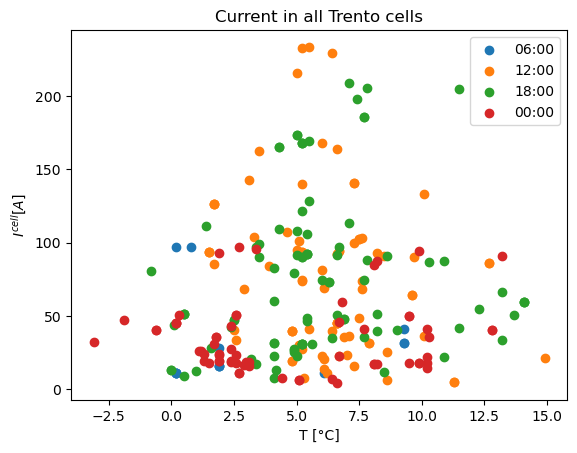

In [268]:
hour = '06:00'
df_h = df_final[df_final['hour_blocks'] == hour]
df_h = df_h[df_h['municipality.name'] == 'Trento']
plt.scatter(df_h['temperature'], df_h['tot_curr_cell'], label=hour)

hour = '12:00'
df_h = df_final[df_final['hour_blocks'] == hour]
df_h = df_h[df_h['municipality.name'] == 'Trento']
plt.scatter(df_h['temperature'], df_h['tot_curr_cell'], label=hour)

hour = '18:00'
df_h = df_final[df_final['hour_blocks'] == hour]
df_h = df_h[df_h['municipality.name'] == 'Trento']
plt.scatter(df_h['temperature'], df_h['tot_curr_cell'], label=hour)

hour = '00:00'
df_h = df_final[df_final['hour_blocks'] == hour]
df_h = df_h[df_h['municipality.name'] == 'Trento']
plt.scatter(df_h['temperature'], df_h['tot_curr_cell'], label=hour)

plt.xlabel('T [°C]')
plt.ylabel(r'$I^{cell} [A]$')
plt.title('Current in all Trento cells')
plt.legend();

Although at 12:00 and 18:00 the current is higher than at 06:00 and 00:00 (reasonable), it looks like all data follows the same distribution, the current being peaked at a temperature and lowering at high and low temperatures. This is probably because at night (low T) people sleep and do not use electricity and during the day (high T) people work and are not at home. We will study later the correlation with tweets.

### Current per site

We still miss the value of current per site. First, we find the number of sites per cell:

In [247]:
df_sites = df_CSD.groupby(['SQUAREID'], as_index=False).agg({'NR_SITES': 'sum'})

In [248]:
df_sites.head()

,SQUAREID,NR_SITES
0,155,4
1,272,72
2,273,21
3,276,34
4,277,3


And we can merge this into `df_final`:

In [251]:
df_twitter_weather_electrical = pd.merge(df_final, df_sites, left_on='cellId', right_on='SQUAREID', how='left').drop('SQUAREID', axis=1)

Again, some cells have no sites, so let's put those NaN values to zero:

In [254]:
df_twitter_weather_electrical['NR_SITES'] = df_twitter_weather_electrical['NR_SITES'].fillna(0)

And finally, we can calculate the current per site:

In [255]:
df_twitter_weather_electrical['curr_site'] = (df_twitter_weather_electrical['tot_curr_cell']/df_twitter_weather_electrical['NR_SITES']).fillna(0)

In [256]:
df_twitter_weather_electrical.head()

,date,time,timestamp,municipality.name,hour_blocks,geometry,station,elevation,minTemperature,maxTemperature,precipitation,minWind,maxWind,temperature,wind,cellId,tot_curr_cell,NR_SITES,curr_site
0,2013-11-01,00:04,1383260656,Trento,00:00,POINT (11.13000 46.07000),T0129,312.0,11.7,16.0,0.0,0.2,2.0,13.2,1@47,5201,90.971940,1288.0,0.070630
1,2013-11-01,00:01,1383260474,Pinzolo,00:00,POINT (10.83000 46.23000),T0071,905.0,4.5,12.3,0.0,0.0,2.5,8.4,0.1@205,7167,1.784586,24.0,0.074358
2,2013-11-01,00:43,1383262983,Cavalese,00:40,POINT (11.46000 46.29000),T0367,958.0,7.0,13.0,0.0,0.0,1.8,8.8,,8151,0.000000,0.0,0.000000
3,2013-11-01,00:38,1383262717,Rovereto,00:30,POINT (11.04000 45.89000),T0147,203.0,11.0,18.4,0.0,0.2,1.9,13.2,0.6@7,2855,47.591226,995.0,0.047830
4,2013-11-01,00:45,1383263140,San Michele all'Adige,00:40,POINT (11.12000 46.20000),T0408,204.0,9.6,16.9,0.0,NaN,NaN,11.6,,6838,0.100372,4.0,0.025093


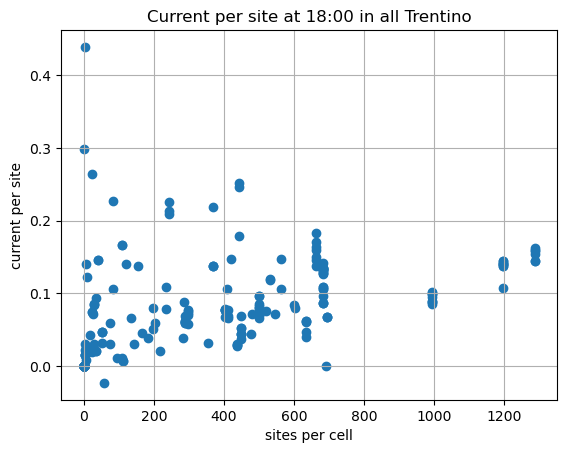

In [279]:
hour = '18:00'
df_h = df_twitter_weather_electrical[df_twitter_weather_electrical['hour_blocks'] == hour]
plt.scatter(df_h['NR_SITES'], df_h['curr_site'])
plt.grid()
plt.xlabel('sites per cell');
plt.ylabel('current per site');
plt.title('Current per site at 18:00 in all Trentino');

## Grouping

In [280]:
df_twitter_weather_electrical

,date,time,timestamp,municipality.name,hour_blocks,geometry,station,elevation,minTemperature,maxTemperature,precipitation,minWind,maxWind,temperature,wind,cellId,tot_curr_cell,NR_SITES,curr_site
0,2013-11-01,00:04,1383260656,Trento,00:00,POINT (11.13000 46.07000),T0129,312.0,11.7,16.0,0.0,0.2,2.0,13.2,1@47,5201,90.971940,1288.0,0.070630
1,2013-11-01,00:01,1383260474,Pinzolo,00:00,POINT (10.83000 46.23000),T0071,905.0,4.5,12.3,0.0,0.0,2.5,8.4,0.1@205,7167,1.784586,24.0,0.074358
2,2013-11-01,00:43,1383262983,Cavalese,00:40,POINT (11.46000 46.29000),T0367,958.0,7.0,13.0,0.0,0.0,1.8,8.8,,8151,0.000000,0.0,0.000000
3,2013-11-01,00:38,1383262717,Rovereto,00:30,POINT (11.04000 45.89000),T0147,203.0,11.0,18.4,0.0,0.2,1.9,13.2,0.6@7,2855,47.591226,995.0,0.047830
4,2013-11-01,00:45,1383263140,San Michele all'Adige,00:40,POINT (11.12000 46.20000),T0408,204.0,9.6,16.9,0.0,NaN,NaN,11.6,,6838,0.100372,4.0,0.025093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27936,2013-12-31,00:25,1388445948,Vigo di Fassa,00:20,POINT (11.68000 46.42000),T0096,1205.0,-10.0,0.3,0.0,NaN,NaN,-7.8,,9922,0.000000,0.0,0.000000
27937,2013-12-29,13:12,1388319166,Predazzo,13:10,POINT (11.60000 46.31000),T0389,1000.0,0.4,3.7,0.0,NaN,NaN,3.4,,8513,0.000000,0.0,0.000000
27938,2013-11-19,00:51,1384818699,Sant'Orsola Terme,00:50,POINT (11.30000 46.11000),T0139,925.0,4.3,6.1,0.0,NaN,NaN,4.8,,5799,0.000000,0.0,0.000000
27939,2013-11-23,09:49,1385196576,Sant'Orsola Terme,09:40,POINT (11.30000 46.11000),T0139,925.0,-1.6,2.6,0.0,NaN,NaN,0.8,,5799,0.000000,0.0,0.000000
